In [1]:
!git clone https://github.com/deril2605/sample.git

Cloning into 'sample'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [2]:
!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 34kB/s 
     |████████████████████████████████| 4.3MB 44.2MB/s 
     |████████████████████████████████| 501kB 54.0MB/s 


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow import keras

In [4]:
model = VGG19(include_top=False, weights='imagenet')
model.trainable=False
model.summary()

80142336/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [5]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
def load_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [7]:
def deprocess_image(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    x=np.clip(x,0,255).astype('uint8')
    return x

In [8]:
def display_image(image):
    if len(image.shape) == 4:
        img=np.squeeze(image,axis=0)
    img = deprocess_image(img)
    plt.grid(False)
    plt.imshow(img)
    return

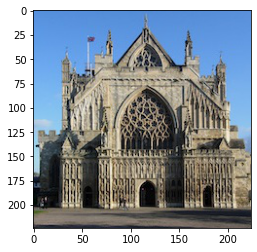

In [10]:
display_image(load_process_image('/content/sample/church.jpg'))

In [11]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1','block3_conv1', 'block5_conv1']
content_model = Model(inputs=model.input, outputs=model.get_layer(content_layer).output)
style_models = [Model(inputs=model.input, outputs=model.get_layer(layer).output) for layer in style_layers]

In [12]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [13]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1,n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a,a,transpose_a=True)
    return G/tf.cast(n, tf.float32)

In [14]:
lam = 1./len(style_models)

def style_cost(style, generated):
    J_style = 0
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        curr_cost = tf.reduce_mean(tf.square(GS-GG))
        J_style += curr_cost*lam
    return J_style

In [15]:
from tqdm import tqdm
generated_images = []
def train_loop(content_path, style_path, iterations=20, alpha=10., beta=20.):
    content = load_process_image(content_path)
    style = load_process_image(style_path)
    
    generated = tf.Variable(content, dtype=tf.float32)
    opt = tf.keras.optimizers.Adam(learning_rate = 7.)
    best_cost = 1e12+0.1
    best_image = None
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content,generated)
            J_style = style_cost(style,generated)
            J_total = alpha*J_content + beta*J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads,generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        print(J_total)
        generated_images.append(generated.numpy())
        # display_image(generated_images[i])
        
    return best_image
        

In [16]:
best_image = train_loop('/content/sample/church.jpg','/content/sample/church_style.jpg')

tf.Tensor(13733986000.0, shape=(), dtype=float32)
tf.Tensor(8505534500.0, shape=(), dtype=float32)
tf.Tensor(5336732700.0, shape=(), dtype=float32)
tf.Tensor(4128790300.0, shape=(), dtype=float32)
tf.Tensor(3317566000.0, shape=(), dtype=float32)
tf.Tensor(2789599500.0, shape=(), dtype=float32)
tf.Tensor(2499382000.0, shape=(), dtype=float32)
tf.Tensor(2265001700.0, shape=(), dtype=float32)
tf.Tensor(2034820500.0, shape=(), dtype=float32)
tf.Tensor(1825326100.0, shape=(), dtype=float32)
tf.Tensor(1641665500.0, shape=(), dtype=float32)
tf.Tensor(1472186000.0, shape=(), dtype=float32)
tf.Tensor(1319807000.0, shape=(), dtype=float32)
tf.Tensor(1196027000.0, shape=(), dtype=float32)
tf.Tensor(1100508900.0, shape=(), dtype=float32)
tf.Tensor(1022388900.0, shape=(), dtype=float32)
tf.Tensor(954916160.0, shape=(), dtype=float32)
tf.Tensor(893662100.0, shape=(), dtype=float32)
tf.Tensor(836673900.0, shape=(), dtype=float32)
tf.Tensor(784928700.0, shape=(), dtype=float32)


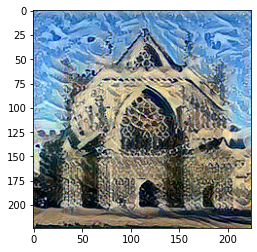

In [18]:
display_image(best_image)